In [2]:
!brew install lightgbm

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
acl2                       halide                     nfpm
act                        hashlink                   ngs
airshare                   hasura-cli                 nicotine-plus
alsa-lib                   heksa                      node@14
amp                        httpx                      notmuch-mutt
apidoc                     hy                         numcpp
arb                        i686-elf-binutils          oci-cli
argo                       i686-elf-gcc               omake
argocd                     idris2                     openfst
arrayfire                  immudb                     openjdk@8
arturo                     infracost                  oq
asimov                     inja                       or-tools
asroute                    inko                       ormolu
athenacli                  ioctl                      ory-hydra
austin           

==> Updated Casks
anaconda ✔
0-ad
010-editor
0xed
115browser
1clipboard
1password
1password-cli
360safe
3cxphone
3dgenceslicer
4k-slideshow-maker
4k-stogram
4k-video-downloader
4k-video-to-mp3
4k-youtube-to-mp3
4peaks
5kplayer
a-better-finder-attributes
a-better-finder-rename
a-slower-speed-of-light
ableton-live
ableton-live-intro
ableton-live-lite
ableton-live-standard
ableton-live-suite
abricotine
abscissa
abstract
accessmenubarapps
accurics
ace-link
acorn
acousticbrainz-gui
acquia-dev
acronis-true-image
acslogo
activedock
activitywatch
actual-odbc-pack
adafruit-arduino
adapter
adguard
adium
adobe-acrobat-pro
adobe-acrobat-reader
adobe-air
adobe-air-sdk
adobe-connect
adobe-creative-cloud
adobe-creative-cloud-cleaner-tool
adobe-digital-editions
adobe-dng-converter
adobe-lens-profile-creator
adoptopenjdk
advancedrestclient
adventure
adware-removal-tool
aegisub
aerial
aether
aexol-remote-mouse
after-dark-classic
agenda
agfeo-dashboard
aimersoft-video-converter-ultimate
air-connect
air-v


==> Downloading https://homebrew.bintray.com/bottles/libomp-11.0.0.catalina.bott
==> Downloading from https://d29vzk4ow07wi7.cloudfront.net/a882de3c79dd02d1fd9c6
######################################################################## 100.0%
==> Downloading https://homebrew.bintray.com/bottles/lightgbm-3.0.0.catalina.bot
######################################################################## 100.0%
==> Installing dependencies for lightgbm: libomp
==> Installing lightgbm dependency: libomp
==> Pouring libomp-11.0.0.catalina.bottle.tar.gz
🍺  /usr/local/Cellar/libomp/11.0.0: 9 files, 1.4MB
==> Installing lightgbm
==> Pouring lightgbm-3.0.0.catalina.bottle.tar.gz
🍺  /usr/local/Cellar/lightgbm/3.0.0: 86 files, 17MB
==> `brew cleanup` has not been run in 30 days, running now...
Removing: /Users/nexxof/Library/Caches/Homebrew/gettext--0.20.2_1.catalina.bottle.tar.gz... (8.4MB)
Removing: /Users/nexxof/Library/Caches/Homebrew/git--2.26.2.catalina.bottle.tar.gz... (17.5MB)
Removing: /Users/nex

In [3]:
import os
import sys
import glob
import pathlib
import numpy as np
import pandas as pd
import pylab as plt

from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE

In [4]:
sys.path.append(os.path.abspath('../src/'))
    
from dpipe_metrics import hausdorff_distance, surface_distances, dice_score, assd, iou

In [5]:
metrics_dict = {
    "dice_coefficient": {"2d": dice_score, "3d": dice_score},
#     "mae": {"2d": lambda x, y: np.abs(x - y).mean(), "3d": lambda x, y: np.abs(x - y).mean()},
#     "mse": {"2d": lambda x, y: ((x - y) ** 2).mean(), "3d": lambda x, y: ((x - y) ** 2).mean()},
    "hausdorff_distance": {"2d": hausdorff_distance, "3d": hausdorff_distance},
    "surface_distances": {"2d": surface_distances, "3d": surface_distances},
    "assd": {"2d": assd, "3d": assd}
}

unary_metrics_dict = {
    "area": {"2d": lambda x: (x > 0).sum(), "3d": lambda x: (x > 0).sum()}
}

In [6]:
from dpipe_metrics import get_matching

In [231]:
class BaseQualityEstimator(BaseEstimator, ClassifierMixin):
    """Base Estimator for segmentation quality assessment"""

    def __init__(self, metrics=["dice_coefficient"], unary_metrics=["area"], meta_clf=LGBMClassifier()):
        """
        Args:
            metrics: list of strings: metrics to be computed on pairs of preds and gt
            unary_metrics: list of string: metrics to be computed on preds directly
        
        TODO: params??
        """
        self.meta_clf = meta_clf
        self.metrics = list(filter(lambda _: _ in metrics_dict, metrics))
        self.unary_metrics = list(filter(lambda _: _ in unary_metrics_dict, unary_metrics))
        
        self.data_type = "3d"
        self.X_metrics = None
    
    
    def fit(self, X, Xy=None, y=None):
        """
        
        """
        assert len(X) == len(Xy) == len(y)
        # get the dimensionality of the data
#         self.data_type = self._check_data_type(X)
        # compute all the metrics on the pairs from X (predictions) and Xy (gt)
        self.X_metrics = self._compute_metrics(X, Xy)
        # fit meta-classifier to metrics and human-made labels
        self.meta_clf.fit(self.X_metrics, y)

        return self
    
    def predict(self, X, Xy):
        
        X_metrics = self._compute_metrics(X, Xy)
        
        y_pred = self.meta_clf.predict(X_metrics)
        
        return y_pred
    
    def predict_proba(self, X, Xy):
        
        X_metrics = self._compute_metrics(X, Xy)
        
        y_pred = self.meta_clf.predict_proba(X_metrics)
        
        return y_pred
    
    def _compute_metrics(self, X, Xy):
        
        def _metrics(x, xy):
            metrics_computed = dict()
            for metric_ in self.metrics:
                metrics_computed[metric_] = metrics_dict[metric_][self.data_type](x, xy)
            return metrics_computed
        
        def _unary_metrics(x):
            unary_metrics_computed = dict()
            for metric_ in self.unary_metrics:
                unary_metrics_computed[metric_] = unary_metrics_dict[metric_][self.data_type](x)
            
            return unary_metrics_computed
        
        def _matching_metrics(x_decomp, xy_decomp):
            matching = get_matching(x_decomp, xy_decomp, metric=iou, metric_ths=[0.1])

            def _match2tpr(matches):

                gt_matches = matches[0]
                gt_unmatched = matches[2]

                n_gt_matched = len(gt_matches)
                n_gt_unmatched = len(gt_unmatched)

                return (n_gt_matched + 1) / (n_gt_matched + n_gt_unmatched + 1)

            def _match2fnr(matches):

                pred_matches = matches[1]
                pred_unmatched = matches[3]

                n_pred_matched = len(pred_matches)
                n_pred_unmatched = len(pred_unmatched)

                return n_pred_unmatched / (n_pred_matched + n_pred_unmatched + 1)
            
            def _match2gtCoverageRate(matches):
                
                coverage_binarization_threshold = 0.7
                
                gt_matches = matches[0]
                gt_unmatched = matches[2]
                
                binary_coverage_instance_list = []
                for gt_instance_matching in gt_matches:
                    instance = gt_instance_matching[0]
                    predictions = gt_instance_matching[1]
                    
                    instance_coverage = np.sum(instance&np.sum(predictions, axis=0, dtype=bool))/np.sum(instance)
                    binary_coverage_instance_list.append(instance_coverage>coverage_binarization_threshold)
                
                n_gt_matched = len(gt_matches)
                n_gt_unmatched = len(gt_unmatched)
                
                
                return np.sum(binary_coverage_instance_list) / (n_gt_matched + n_gt_unmatched + 1)
            
            def _match2predCoverageRate(matches):
                
                coverage_binarization_threshold = 0.3
                
                pred_matches   = matches[1]
                pred_unmatched = matches[3]
                
                binary_coverage_instance_list = []
                for pred_instance_matching in pred_matches:
                    instance    = pred_instance_matching[0]
                    gts = pred_instance_matching[1]
                    
                    instance_coverage = np.sum(instance&np.sum(gts, axis=0, dtype=bool))/np.sum(instance)
                    binary_coverage_instance_list.append(instance_coverage>coverage_binarization_threshold)
                
                n_pred_matched = len(pred_matches)
                n_pred_unmatched = len(pred_unmatched)
                
                
                return np.sum(binary_coverage_instance_list) / (n_pred_matched + n_pred_unmatched + 1)
            
            tpr = _match2tpr(matching[0])
            fnr = _match2fnr(matching[0])
            gtCovThrRate   = _match2gtCoverageRate(matching[0])
            predCovThrRate = _match2predCoverageRate(matching[0])
            return {"gtCovThrRate": gtCovThrRate, "predCovThrRate": predCovThrRate}
        
        metrics_computed = []
        
        for x_, xy_ in zip(X, Xy):
            metrics_temp_ = _metrics(x_[0], xy_[0])
            metrics_temp_.update(_unary_metrics(x_[0]))
            matching_metrics_temp_ = _matching_metrics(x_[1:], xy_[1:])
            metrics_temp_.update(matching_metrics_temp_)
            metrics_computed.append(metrics_temp_)
            
        df_metrics_computed = pd.DataFrame(metrics_computed)
        
        return df_metrics_computed
        
    def _check_data_type(self, X):
        """
        TODO:
        """
        # заглушка:
        if len(X.shape) == 2:
            return "2d"
        elif X.shape[2] == 1:
            return "2d"
        else:
            return "3d"

    def score(self, X, y=None):
        # counts number of values bigger than mean
        return(sum(self.predict(X))) 

### Check metrics:

In [232]:
y_df = pd.read_csv("../data/OpenPart.csv")

In [233]:
X = np.array([plt.imread(_) for _ in sorted(glob.glob("../data/sample_2/*"))]).astype(bool)

In [234]:
full_X = []
full_Xy = []
full_y = []

for i in range(1, 4):
    # X = np.array([plt.imread(_) for _ in sorted(glob.glob("../data/sample_1/*"))]).astype(bool)
    X = [np.load(_) for _ in sorted(glob.glob("../data/decomposed/sample_" + str(i) + "/*"))]
    # X_ids = [_.split("/")[-1] for _ in sorted(glob.glob("../data/sample_1/*"))]
    X_ids = [_.split("/")[-1] for _ in sorted(glob.glob("../data/decomposed/sample_" + str(i) + "/*"))]
    # Xy = np.array([plt.imread(_) for _ in glob.glob("../data/after/*")]).astype(bool)
    Xy = [np.load(_) for _ in sorted(glob.glob("../data/decomposed/after/*"))]
    # Xy_ids = [_.split("/")[-1] for _ in sorted(glob.glob("../data/after/*"))]
    Xy_ids = [_.split("/")[-1] for _ in sorted(glob.glob("../data/decomposed/after/*"))]

    y = y_df.sort_values(by="Case")["Sample " + str(i)].values
    y_ids = y_df.sort_values(by="Case")["Case"].values

    X_not_ids = [X_ids[i] for i in range(len(X)) if X_ids[i].split(".")[0] + ".png" not in y_ids]

    X = np.array([X[i] for i in range(len(X)) if X_ids[i].split(".")[0] + ".png" in y_ids])
    Xy = np.array([Xy[i] for i in range(len(Xy)) if Xy_ids[i].split(".")[0] + ".png" in y_ids])
    
    full_X = list(full_X) + list(X)
    full_Xy = list(full_Xy) + list(Xy)
    full_y = list(full_y) + list(y)
    
X = np.array(full_X)
Xy = np.array(full_Xy)
y = np.array(full_y)

In [235]:
X_train, X_eval, Xy_train, Xy_eval, y_train, y_eval = train_test_split(X, Xy, y, test_size=0.2, random_state=9)

In [236]:
q_clf = BaseQualityEstimator(metrics=["dice_coefficient", 
                                      #"mae", "mse", 
#                                       "hausdorff_distance", 
#                                       "surface_distances",
#                                       "assd"
                                     ], 
                             unary_metrics=[],#["area"],
                             meta_clf=LGBMClassifier(max_depth=3))

In [237]:
X_train.shape, Xy_train.shape, y_train.shape

((144,), (144,), (144,))

In [238]:
q_clf.fit(X_train, Xy_train, y_train)

BaseQualityEstimator(meta_clf=LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=3,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=None, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=True,
                                             subsample=1.0,
                                             subsample_for_bin=200000,
                    

In [239]:
y_pred = q_clf.predict(X_eval, Xy_eval)

In [240]:
y_dummy = np.array([3 for i in range(len(y_eval))])

In [241]:
y_pred

array([2, 4, 5, 4, 2, 3, 1, 1, 5, 2, 1, 5, 4, 5, 3, 5, 2, 3, 3, 4, 3, 5,
       3, 4, 3, 3, 3, 2, 5, 2, 3, 5, 5, 3, 3, 5])

In [242]:
y_eval

array([2, 5, 5, 3, 2, 2, 1, 1, 1, 1, 1, 5, 4, 4, 3, 4, 3, 3, 1, 2, 3, 5,
       3, 4, 4, 3, 4, 2, 5, 3, 2, 5, 2, 4, 4, 5])

In [243]:
y_dummy

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [244]:
MAE(y_eval, y_dummy)

1.1388888888888888

In [245]:
MAE(y_eval, y_pred)

0.6666666666666666

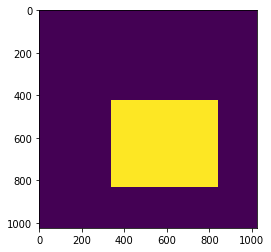

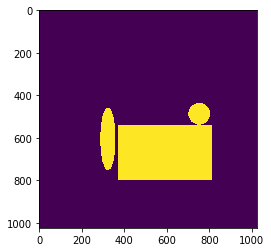

In [248]:
plt.imshow(X_eval[-4][0])
plt.show()
plt.imshow(Xy_eval[-4][0])
plt.show()



In [249]:
q_clf.X_metrics.tail(10)

,dice_coefficient,gtCovThrRate,predCovThrRate
134,0.132777,0.166667,0.250000
135,1.000000,0.000000,0.000000
136,0.678427,0.250000,0.500000
137,0.417343,0.000000,0.500000
138,0.010053,0.000000,0.000000
139,0.190660,0.000000,0.333333
140,0.000000,0.000000,0.000000
141,0.000000,0.000000,0.000000
142,0.707647,0.000000,0.333333
143,0.893732,0.500000,0.500000
